In [6]:
!pip install pandas_datareader

/var/folders/2p/8smjtq9s6cs2v0cq4hdsjs9h0000gn/T/ipykernel_30020/1800136972.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gdp_df = gdp_df.resample('M').ffill()  # 转为月度并前向填充


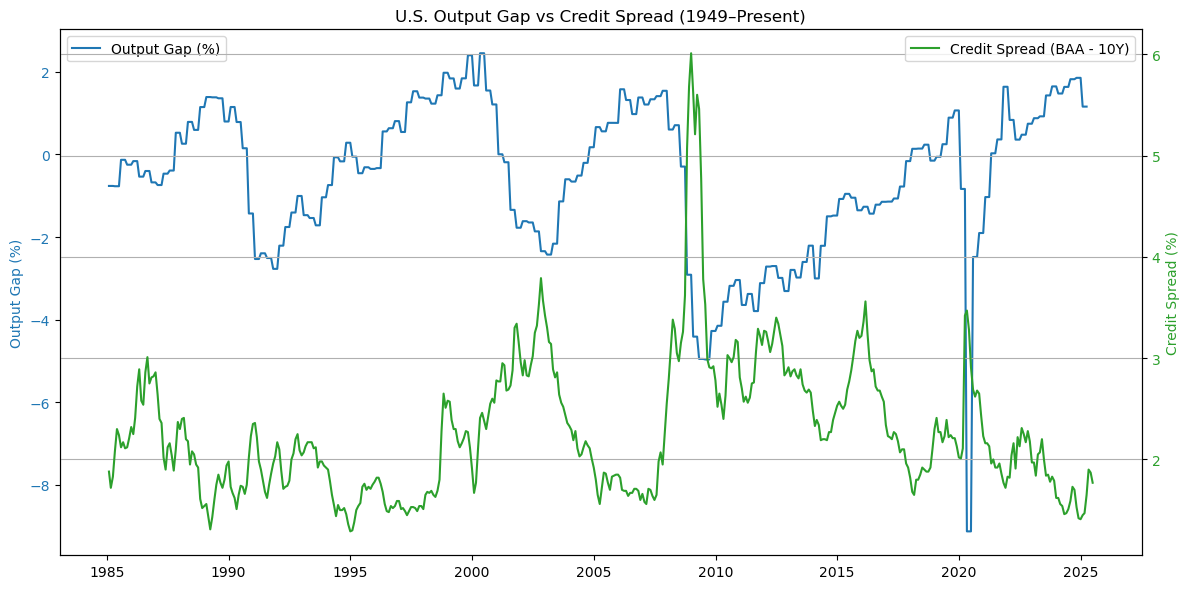

            Actual_GDP  Potential_GDP  Output_Gap
DATE                                             
2024-10-31   23542.349       23113.34    1.856110
2024-11-30   23542.349       23113.34    1.856110
2024-12-31   23542.349       23113.34    1.856110
2025-01-31   23512.717       23243.22    1.159465
2025-02-28   23512.717       23243.22    1.159465
2025-03-31   23512.717       23243.22    1.159465
2025-04-30         NaN       23376.07         NaN
2025-05-31         NaN       23376.07         NaN
2025-06-30         NaN       23376.07         NaN
2025-07-31         NaN       23510.18         NaN
=== Pearson Correlation (r, p) ===
Output Gap ~ Credit Spread   : r = nan, p = nan

=== Regression: Output_Gap ~ Credit_Spread ===
                            OLS Regression Results                            
Dep. Variable:             Output_Gap   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Sq

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as pdr

# 设置时间范围
start_date = '1985-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# 下载季度GDP数据
actual_gdp = pdr.DataReader('GDPC1', 'fred', start_date, end_date)
potential_gdp = pdr.DataReader('GDPPOT', 'fred', start_date, end_date)

# 合并并计算Output Gap
gdp_df = pd.concat([actual_gdp, potential_gdp], axis=1)
gdp_df.columns = ['Actual_GDP', 'Potential_GDP']
gdp_df['Output_Gap'] = 100 * (gdp_df['Actual_GDP'] - gdp_df['Potential_GDP']) / gdp_df['Potential_GDP']
gdp_df = gdp_df.resample('M').ffill()  # 转为月度并前向填充

# Credit Spread
# 下载信用利差相关数据
baa_yield = pdr.DataReader('BAA', 'fred', start_date, end_date)
treasury_yield = pdr.DataReader('GS10', 'fred', start_date, end_date)

credit_df = pd.concat([baa_yield, treasury_yield], axis=1)
credit_df.columns = ['BAA_Yield', 'Treasury_Yield']
credit_df['Credit_Spread'] = credit_df['BAA_Yield'] - credit_df['Treasury_Yield']

# 修正索引：将月初对齐为月末
credit_df.index = credit_df.index.to_period('M').to_timestamp('M')

# 合并为一个DataFrame，确保索引对齐
df = gdp_df[['Output_Gap']].join(credit_df[['Credit_Spread']], how='inner')

# 绘图
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Output Gap (左轴)
ax1.plot(df.index, df['Output_Gap'], label='Output Gap (%)', color='tab:blue')
ax1.set_ylabel('Output Gap (%)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Credit Spread (右轴)
ax2.plot(df.index, df['Credit_Spread'], label='Credit Spread (BAA - 10Y)', color='tab:green')
ax2.set_ylabel('Credit Spread (%)', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

# 标题与图例
plt.title('U.S. Output Gap vs Credit Spread (1949–Present)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/2p/8smjtq9s6cs2v0cq4hdsjs9h0000gn/T/ipykernel_30020/2701508029.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  delinquency = pdr.DataReader('DRALACBS', 'fred', start_date, end_date).resample('M').ffill()


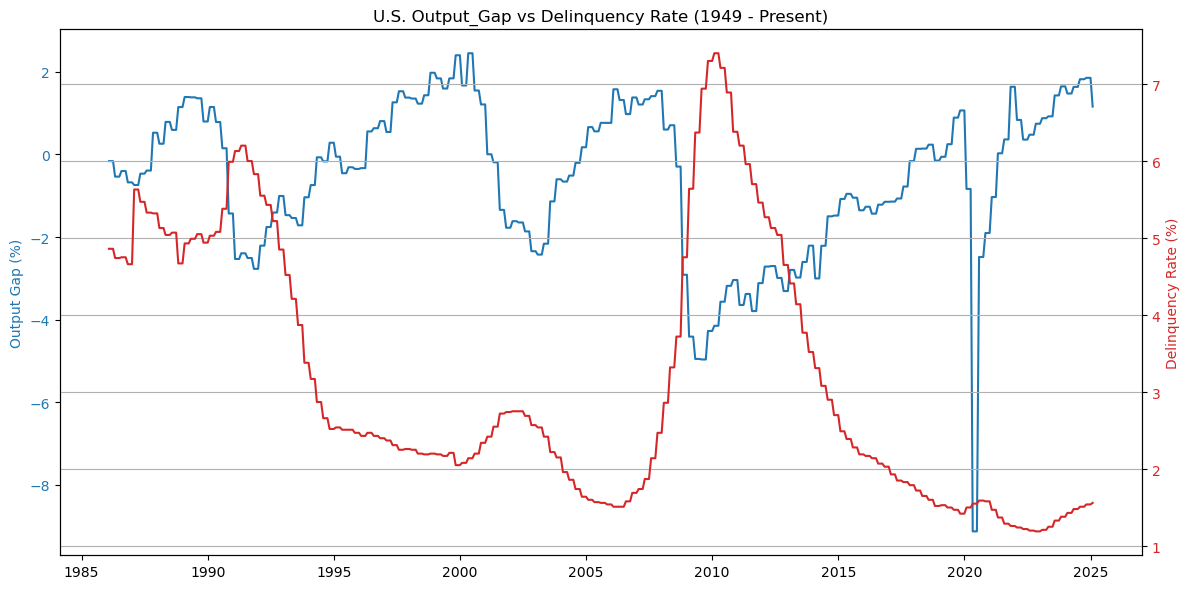

In [55]:
# Delinquency Rate
# 下载违约率（美国所有贷款违约率）
delinquency = pdr.DataReader('DRALACBS', 'fred', start_date, end_date).resample('M').ffill()

df2 = gdp_df[['Output_Gap']].join([delinquency,loan_growth],how = 'inner')
df2.columns = ['Output_Gap', 'Delinquency_Rate', 'Loan_Growth']
df2.dropna(inplace=True)

plt.figure(figsize = (12,6))
ax1 = plt.gca()
ax2 = ax1.twinx()

ax2.plot(df2.index, df2['Delinquency_Rate'], color='tab:red', label='Delinquency Rate (%)')
ax2.set_ylabel('Delinquency Rate (%)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.plot(df2.index, df2['Output_Gap'], label='Output Gap (%)', color='tab:blue')
ax1.set_ylabel('Output Gap (%)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

plt.title('U.S. Output_Gap vs Delinquency Rate (1949 - Present)')
plt.grid(True)
plt.tight_layout()
plt.show()

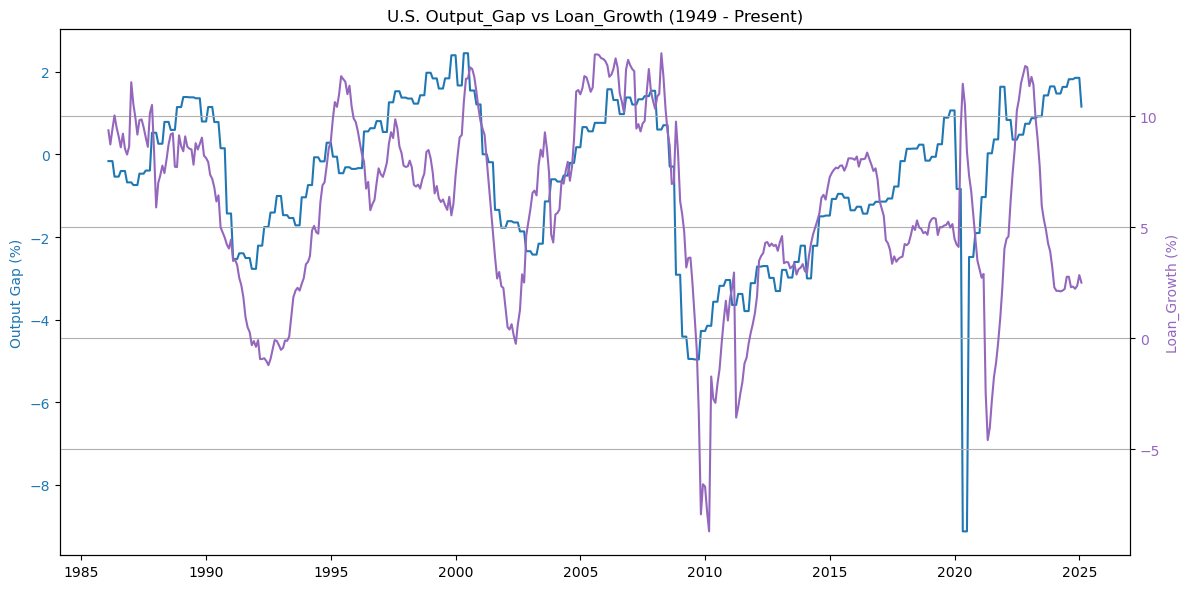

In [49]:
# Loan Growth

plt.figure(figsize = (12,6))
ax1 = plt.gca()
ax2 = ax1.twinx()

ax2.plot(df2.index, df2['Loan_Growth'], color='tab:purple', label='Loan_Growth (%)')
ax2.set_ylabel('Loan_Growth (%)', color='tab:purple')
ax2.tick_params(axis='y', labelcolor='tab:purple')

ax1.plot(df2.index, df2['Output_Gap'], label='Output Gap (%)', color='tab:blue')
ax1.set_ylabel('Output Gap (%)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

plt.title('U.S. Output_Gap vs Loan_Growth (1949 - Present)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# STATA
import statsmodels.api as sm
from scipy import stats

r1, p1 = stats.pearsonr(df2['Output_Gap'], df2['Delinquency_Rate'])
r2, p2 = stats.pearsonr(df2['Output_Gap'], df2['Loan_Growth'])
r3, p3 = stats.pearsonr(df['Output_Gap'], df['Credit_Spread'])

print("=== Pearson Correlation (r, p) ===")
print(f"Output Gap ~ Delinquency Rate: r = {r1:.3f}, p = {p1:.3e}")
X1 = sm.add_constant(df2[['Delinquency_Rate']])
model1 = sm.OLS(df2['Output_Gap'], X1).fit()
print("\n=== Regression: Output_Gap ~ Delinquency_Rate ===")
print(model1.summary())



=== Pearson Correlation (r, p) ===
Output Gap ~ Delinquency Rate: r = -0.535, p = 4.988e-36

=== Regression: Output_Gap ~ Delinquency_Rate ===
                            OLS Regression Results                            
Dep. Variable:             Output_Gap   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     186.9
Date:                Fri, 18 Jul 2025   Prob (F-statistic):           4.99e-36
Time:                        15:20:08   Log-Likelihood:                -868.15
No. Observations:                 469   AIC:                             1740.
Df Residuals:                     467   BIC:                             1749.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [

In [59]:
print("=== Pearson Correlation (r, p) ===")
print(f"Output Gap ~ Loan Growth    : r = {r2:.3f}, p = {p2:.3e}")
X2 = sm.add_constant(df2[['Loan_Growth']])
model2 = sm.OLS(df2['Output_Gap'], X2).fit()
print("\n=== Regression: Output_Gap ~ Loan_Growth ===")
print(model2.summary())

=== Pearson Correlation (r, p) ===
Output Gap ~ Loan Growth    : r = 0.506, p = 8.170e-32

=== Regression: Output_Gap ~ Loan_Growth ===
                            OLS Regression Results                            
Dep. Variable:             Output_Gap   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     160.4
Date:                Fri, 18 Jul 2025   Prob (F-statistic):           8.17e-32
Time:                        15:22:21   Log-Likelihood:                -877.84
No. Observations:                 469   AIC:                             1760.
Df Residuals:                     467   BIC:                             1768.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0

In [64]:

df_clean = df[['Output_Gap', 'Credit_Spread']].dropna()
print("=== Pearson Correlation (r, p) ===")
print(f"Output Gap ~ Credit Spread   : r = {r3:.3f}, p = {p3:.3e}")
X3 = sm.add_constant(df_clean[['Credit_Spread']])
model3 = sm.OLS(df_clean['Output_Gap'], X3).fit()
print("\n=== Regression: Output_Gap ~ Credit_Spread ===")
print(model3.summary())

=== Pearson Correlation (r, p) ===
Output Gap ~ Credit Spread   : r = nan, p = nan

=== Regression: Output_Gap ~ Credit_Spread ===
                            OLS Regression Results                            
Dep. Variable:             Output_Gap   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     290.9
Date:                Fri, 18 Jul 2025   Prob (F-statistic):           2.31e-51
Time:                        15:26:56   Log-Likelihood:                -855.08
No. Observations:                 483   AIC:                             1714.
Df Residuals:                     481   BIC:                             1723.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.97

In [65]:
#multi
df_full = df2[['Output_Gap', 'Delinquency_Rate', 'Loan_Growth']].join(df[['Credit_Spread']], how='inner')
df_full.dropna(inplace=True)

X = sm.add_constant(df_full[['Delinquency_Rate', 'Loan_Growth', 'Credit_Spread']])
y = df_full['Output_Gap']

model_all = sm.OLS(y, X).fit()

print("=== Regression: Output_Gap ~ Delinquency + Loan Growth + Credit Spread ===")
print(model_all.summary())

=== Regression: Output_Gap ~ Delinquency + Loan Growth + Credit Spread ===
                            OLS Regression Results                            
Dep. Variable:             Output_Gap   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     224.7
Date:                Fri, 18 Jul 2025   Prob (F-statistic):           4.49e-90
Time:                        15:32:23   Log-Likelihood:                -736.99
No. Observations:                 469   AIC:                             1482.
Df Residuals:                     465   BIC:                             1499.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------